<a href="https://colab.research.google.com/github/aasifahmed23/AI-ML-/blob/main/Asif_DLCP_Project1_Milestone2_v4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Build a simple Neural Network on SVHN dataset

#### Import the data from drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
np.seterr(over='ignore')
import os
import matplotlib.pyplot as plt
import h5py
import numpy as np

In [ ]:
import h5py
import numpy as np

# Open the file as readonly
#h5f = h5py.File('SVHN_single_grey1.h5', 'r')
h5f = h5py.File('/content/drive/My Drive/DLCP/Project-1/Data/SVHN_single_grey1.h5', 'r')

# Load the training, test and validation set
x_train = h5f['X_train'][:]
y_train_old = h5f['y_train'][:]
x_test = h5f['X_test'][:]
y_test_old = h5f['y_test'][:]


# Close this file
h5f.close()

x_train_old = x_train.reshape(x_train.shape[0], 1024)
# Reduced the training data set to 3K images
x_train = x_train_old[:30000,:]
x_test_old = x_test.reshape(x_test.shape[0], 1024)
# Reduced the test data set to 1K images
x_test = x_test_old[:10000,:]
y_train = y_train_old[:30000,]
y_test = y_test_old[:10000,]

# # normalize inputs from 0-255 to 0-1
x_train = x_train / 255.0
x_test = x_test / 255.0

X_train = x_train


X_val = x_test
y_val = y_test

print('Training set', x_train.shape, y_train.shape)
print('Test set', x_test.shape, y_test.shape)

Training set (30000, 1024) (30000,)
Test set (10000, 1024) (10000,)


In [ ]:
print(x_train.shape)
print(y_train.shape)

(30000, 1024)
(30000,)


In [ ]:
print(x_test.shape)
print(y_test.shape)

(10000, 1024)
(10000,)


### Neural network from scratch

#### Fully Connected Layer (Linear Layer)

In [ ]:
class Linear():
    def __init__(self, in_size, out_size):
        self.W = np.random.randn(in_size, out_size) * 0.01
        self.b = np.zeros((1, out_size))
        self.params = [self.W, self.b]
        self.gradW = None
        self.gradB = None
        self.gradInput = None

    def forward(self, X):
        self.X = X
        self.output = np.dot(X, self.W) + self.b
        return self.output

    def backward(self, nextgrad):
        self.gradW = np.dot(self.X.T, nextgrad)
        self.gradB = np.sum(nextgrad, axis=0)
        self.gradInput = np.dot(nextgrad, self.W.T)
        return self.gradInput, [self.gradW, self.gradB]

#### Rectified Linear Activation Layer (ReLU)


In [ ]:
class ReLU():
    def __init__(self):
        self.params = []
        self.gradInput = None

    def forward(self, X):
        self.output = np.maximum(X, 0)
        return self.output

    def backward(self, nextgrad):
        self.gradInput = nextgrad.copy()
        self.gradInput[self.output <=0] = 0
        return self.gradInput, []

#### Define softmax function

In [ ]:
def softmax(x):
    exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
    return exp_x / np.sum(exp_x, axis=1, keepdims=True)

#### Define the Cross Entropy Loss

In [ ]:
class CrossEntropy:
    def forward(self, X, y):
        self.m = y.shape[0]
        self.p = softmax(X)
        cross_entropy = -np.log(self.p[range(self.m), y]+1e-16)
        loss = np.sum(cross_entropy) / self.m
        return loss

    def backward(self, X, y):
        y_idx = y.argmax()
        grad = softmax(X)
        grad[range(self.m), y] -= 1
        grad /= self.m
        return grad

#### Define the container NN class that enables the forward prop and backward propagation of the entire network. Note, how this class enables us to add layers of different types and also correctly pass gradients using the chain rule.

In [ ]:
class NN():
    def __init__(self, lossfunc=CrossEntropy(), mode='train'):
        self.params = []
        self.layers = []
        self.loss_func = lossfunc
        self.grads = []
        self.mode = mode
        self.loss_n_accuracy = []


    def add_layer(self, layer):
        self.layers.append(layer)
        self.params.append(layer.params)

    def forward(self, X):
        for layer in self.layers:
            X = layer.forward(X)
        return X

    def backward(self, nextgrad):
        self.clear_grad_param()
        for layer in reversed(self.layers):
            nextgrad, grad = layer.backward(nextgrad)
            self.grads.append(grad)
        return self.grads

    def train_step(self, X, y):
        out = self.forward(X)
        loss = self.loss_func.forward(out,y)
        nextgrad = self.loss_func.backward(out,y)
        grads = self.backward(nextgrad)
        return loss, grads

    def predict(self, X):
        X = self.forward(X)
        p = softmax(X)
        return np.argmax(p, axis=1)

    def predict_scores(self, X):
        X = self.forward(X)
        p = softmax(X)
        return p

    def clear_grad_param(self):
        self.grads = []

    def loss_n_accuracy_update(self,X):
        self.loss_n_accuracy.append(X)

#### Define the update function (SGD with momentum)

In [ ]:
def update_params(velocity, params, grads, learning_rate=0.01, mu=0.9):
    for v, p, g, in zip(velocity, params, reversed(grads)):
        for i in range(len(g)):
            v[i] = mu * v[i] - learning_rate * g[i]
            p[i] += v[i]

#### Define a function which gives us the minibatches (both the datapoint and the corresponding label)

In [ ]:
# get minibatches
def minibatch(X, y, minibatch_size):
    n = X.shape[0]
    minibatches = []
    permutation = np.random.permutation(X.shape[0])
    X = X[permutation]
    y = y[permutation]

    for i in range(0, n , minibatch_size):
        X_batch = X[i:i + minibatch_size, :]
        y_batch = y[i:i + minibatch_size, ]
        minibatches.append((X_batch, y_batch))

    return minibatches

In [ ]:
def train(net, X_train, y_train, minibatch_size, epoch, learning_rate, mu=0.9, X_val=None, y_val=None):

    val_loss_epoch = []
    loss_n_accuracy = []

    minibatches = minibatch(X_train, y_train, minibatch_size)
    minibatches_val = minibatch(X_val, y_val, minibatch_size)


    for i in range(epoch):
        loss_batch = []
        val_loss_batch = []
        velocity = []
        for param_layer in net.params:
            p = [np.zeros_like(param) for param in list(param_layer)]
            velocity.append(p)

        # iterate over mini batches
        for X_mini, y_mini in minibatches:
            loss, grads = net.train_step(X_mini, y_mini)
            loss_batch.append(loss)
            update_params(velocity, net.params, grads, learning_rate=learning_rate, mu=mu)

        for X_mini_val, y_mini_val in minibatches_val:
            val_loss, _ = net.train_step(X_mini, y_mini)
            val_loss_batch.append(val_loss)

        # accuracy of model at end of epoch after all mini batch updates
        m_train = X_train.shape[0]
        m_val = X_val.shape[0]
        y_train_pred = np.array([], dtype="int64")
        y_val_pred = np.array([], dtype="int64")
        y_train1 = []
        y_vall = []
        for i in range(0, m_train, minibatch_size):
            X_tr = X_train[i:i + minibatch_size, : ]
            y_tr = y_train[i:i + minibatch_size,]
            y_train1 = np.append(y_train1, y_tr)
            y_train_pred = np.append(y_train_pred, net.predict(X_tr))

        for i in range(0, m_val, minibatch_size):
            X_va = X_val[i:i + minibatch_size, : ]
            y_va = y_val[i:i + minibatch_size,]
            y_vall = np.append(y_vall, y_va)
            y_val_pred = np.append(y_val_pred, net.predict(X_va))

        train_acc = check_accuracy(y_train1, y_train_pred)
        val_acc = check_accuracy(y_vall, y_val_pred)

        mean_train_loss = sum(loss_batch) / float(len(loss_batch))
        mean_val_loss = sum(val_loss_batch) / float(len(val_loss_batch))

        val_loss_epoch.append(mean_val_loss)

        #print("Loss = {0} | Training Accuracy = {1} | Val Loss = {2} | Val Accuracy = {3}".format(mean_train_loss, train_acc, mean_val_loss, val_acc))
    net.loss_n_accuracy_update((np.concatenate((mean_train_loss, train_acc, mean_val_loss, val_acc), axis=None)))
    return net

In [ ]:
def check_accuracy(y_true, y_pred):
    return np.mean(y_pred == y_true)

In [ ]:
from random import shuffle

## input size
input_dim = x_train.shape[1]

## hyperparameters
iterations = 10
learning_rate = np.linspace(1e-2,1e-3,10)
x = np.size(learning_rate)
hidden_nodes = 32
output_nodes = 10

## define neural net
nn = NN()
nn.add_layer(Linear(input_dim, hidden_nodes))
nn.add_layer(ReLU())
nn.add_layer(Linear(hidden_nodes, output_nodes))

for i in range(np.size(learning_rate)):

    nn = train(nn, X_train , y_train, minibatch_size=500, epoch=300, \
           learning_rate=learning_rate[i], X_val=X_val, y_val=y_val)



In [ ]:
# Convert the list (containing Training Loss, Training Accuracy,Val loss and Accuracy) captured after sweeping the learning_rate from 1e-2 to 1e-3 into an array
p = np.array(nn.loss_n_accuracy)
p


array([[0.68165239, 0.79403333, 0.77516096, 0.7653    ],
       [0.60211364, 0.81773333, 0.78385986, 0.7758    ],
       [0.54040228, 0.8249    , 0.71492943, 0.774     ],
       [0.50983973, 0.84413333, 0.63165255, 0.7876    ],
       [0.48721711, 0.852     , 0.52801422, 0.7865    ],
       [0.46141442, 0.85796667, 0.6076008 , 0.7903    ],
       [0.44527248, 0.87036667, 0.58002166, 0.7946    ],
       [0.43158323, 0.86903333, 0.43340284, 0.7914    ],
       [0.42041927, 0.8736    , 0.47009378, 0.7966    ],
       [0.41304971, 0.87963333, 0.33862099, 0.7939    ]])

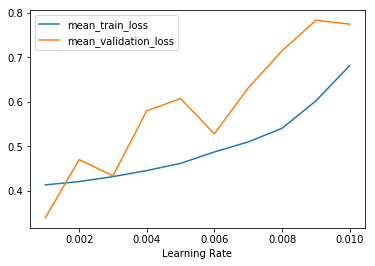

In [ ]:
# Plot the Variation of Training loss and Validation Loss with Learning rate
%matplotlib inline
plt.plot(learning_rate,p[:,0],label='mean_train_loss')
plt.plot(learning_rate,p[:,2],label='mean_validation_loss')
plt.xlabel("Learning Rate")
plt.legend()

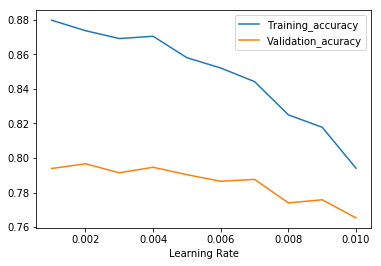

In [ ]:
# Plot the Variation of Training accuracy and Validation accuracy with Learning rate
%matplotlib inline
plt.plot(learning_rate,p[:,1],label='Training_accuracy')
plt.plot(learning_rate,p[:,3],label='Validation_acuracy')
plt.xlabel("Learning Rate")
plt.legend()

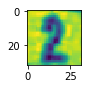

In [ ]:
%matplotlib inline
fig=plt.figure(figsize=(1,1))
plt.imshow(X_val[2].reshape(32,32))

In [ ]:
# Predict Scores for each class
prediction = nn.predict_scores(X_val[2])[0]

In [ ]:
print ("Scores")
print (prediction)

Scores
[4.05350791e-06 2.52583524e-05 9.90511284e-01 8.60415046e-05
 2.03063622e-06 8.33237715e-09 2.08827488e-07 3.42060151e-05
 9.09066746e-03 2.46240985e-04]
